In [15]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd 

In [16]:
dataset = pd.read_csv('diabetes.csv')

X = dataset.iloc[:,0:8]
Y = dataset.iloc[:,8]

In [17]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [11]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [13]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.95%


xgboost 可以在模型训练时，评价模型在测试集上的表现，也可以输出每一步的分数

In [19]:
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.660186
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.634854
[2]	validation_0-logloss:0.612239
[3]	validation_0-logloss:0.593118
[4]	validation_0-logloss:0.578303
[5]	validation_0-logloss:0.564942
[6]	validation_0-logloss:0.555113
[7]	validation_0-logloss:0.54499
[8]	validation_0-logloss:0.539151
[9]	validation_0-logloss:0.531819
[10]	validation_0-logloss:0.526065
[11]	validation_0-logloss:0.51977
[12]	validation_0-logloss:0.514979
[13]	validation_0-logloss:0.50927
[14]	validation_0-logloss:0.506086
[15]	validation_0-logloss:0.503565
[16]	validation_0-logloss:0.503591
[17]	validation_0-logloss:0.500805
[18]	validation_0-logloss:0.497605
[19]	validation_0-logloss:0.495328
[20]	validation_0-logloss:0.494777
[21]	validation_0-logloss:0.494274
[22]	validation_0-logloss:0.493333
[23]	validation_0-logloss:0.492211
[24]	validation_0-logloss:0.491936
[25]	validation_0-logloss:0.490578
[26]	validation_0-logloss:0.490895


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

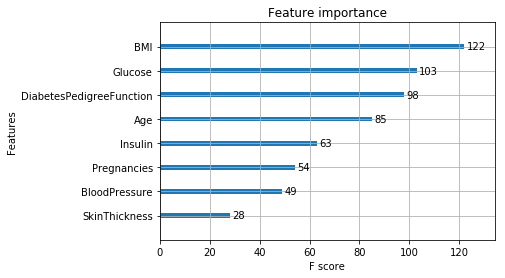

In [22]:
#输出特征重要度
from xgboost import plot_importance
from matplotlib import pyplot

model.fit(X, Y)

plot_importance(model)
pyplot.show()

#调参
如何调参呢，下面是三个超参数的一般实践最佳值，可以先将它们设定为这个范围，然后画出 learning curves，再调解参数找到最佳模型：

learning_rate ＝ 0.1 或更小，越小就需要多加入弱学习器；
tree_depth ＝ 2～8；
subsample ＝ 训练集的 30%～80%；
接下来我们用 GridSearchCV 来进行调参会更方便一些：

可以调的超参数组合有：

树的个数和大小 (n_estimators and max_depth).
学习率和树的个数 (learning_rate and n_estimators).
行列的 subsampling rates (subsample, colsample_bytree and colsample_bylevel).

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
model = XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, Y)

In [24]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.483013 using {'learning_rate': 0.1}


In [25]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.689650 (0.000242) with: {'learning_rate': 0.0001}
-0.661274 (0.001954) with: {'learning_rate': 0.001}
-0.530747 (0.022961) with: {'learning_rate': 0.01}
-0.483013 (0.060755) with: {'learning_rate': 0.1}
-0.515440 (0.068974) with: {'learning_rate': 0.2}
-0.557315 (0.081738) with: {'learning_rate': 0.3}
